In [3]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt


# Data Generation
$$ x \in [0, 4\pi] $$
$$ f_1(x) = \sin(x) $$
$$ f_2(x) = \cos(x) $$
$$ \text{loc}(x) = f_1(x) $$
$$ \text{scale}(x) = \exp(f_2(x)) $$
$$ y|x \sim \mathcal{N}(\text{loc}(x),\;\text{scale}^2(x))$$



In [4]:
N = 1001
M = 20

np.random.seed(0)
tf.random.set_seed(0)

X = np.linspace(0, 4*np.pi, N)[:, None]

F1 = np.sin(X)
F2 = np.cos(X)
F = np.hstack([F1, F2])

loc = F1
scale = np.exp(F2)

Y = np.random.normal(loc, scale)
Z = np.linspace(X.min(), X.max(), M)[:, None]

# Plot Data

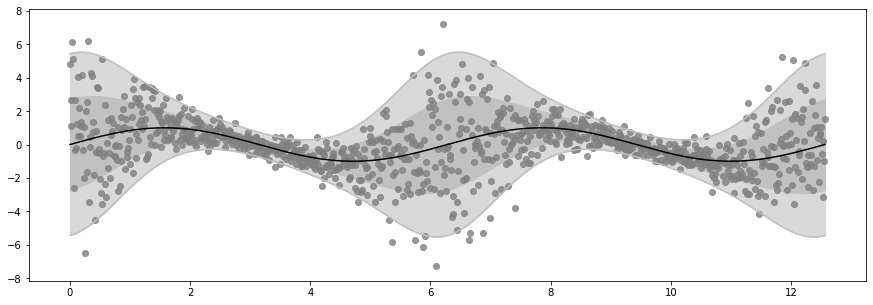

In [5]:
plt.figure(figsize=(15, 5))
for k in (1,2):
    x = X.squeeze()
    lb = (loc - k*scale).squeeze()
    ub = (loc + k*scale).squeeze()
    plt.fill_between(x, lb, ub, color='silver', alpha=1 - .05*k**3)
plt.plot(x, lb, color='silver')
plt.plot(x, ub, color='silver')
plt.plot(X, loc, color='black')
plt.scatter(X, Y, color='gray', alpha=.8)


# Build Model

In [6]:
likelihood = gpf.likelihoods.heteroskedastic.HeteroskedasticTFPDistribution(
    tfp.distributions.Normal
)

kernel = gpf.kernels.SeparateIndependent([
    gpf.kernels.RBF()
    for _ in range(likelihood.latent_dim)
])

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables([
    gpf.inducing_variables.InducingPoints(Z)
    for _ in range(likelihood.latent_dim)
])

model = gpf.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim
)

# Build Optimizers (NatGrad + Adam)

In [11]:
loss_fn = model.training_loss_closure(data)

gpf.utilities.set_trainable(model.q_mu, False)
gpf.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=.01)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(.01)

# Run Optimization Loop

In [12]:
epochs = 100
log_freq = 10

for epoch in range(epochs + 1):
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)
    if epoch % log_freq == 0:
        print(f'Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}')

Epoch 0 - Loss:  1889.4279
Epoch 10 - Loss:  1708.9915
Epoch 20 - Loss:  1586.1565
Epoch 30 - Loss:  1516.1665
Epoch 40 - Loss:  1483.7233
Epoch 50 - Loss:  1470.1566
Epoch 60 - Loss:  1463.4123
Epoch 70 - Loss:  1459.5669
Epoch 80 - Loss:  1457.1189
Epoch 90 - Loss:  1455.4233
Epoch 100 - Loss:  1454.1813


# Plot Results

In [13]:
Ymean, Yvar = model.predict_y(X)
Ymean = Ymean.numpy().squeeze()
Ystd = tf.sqrt(Yvar).numpy().squeeze()

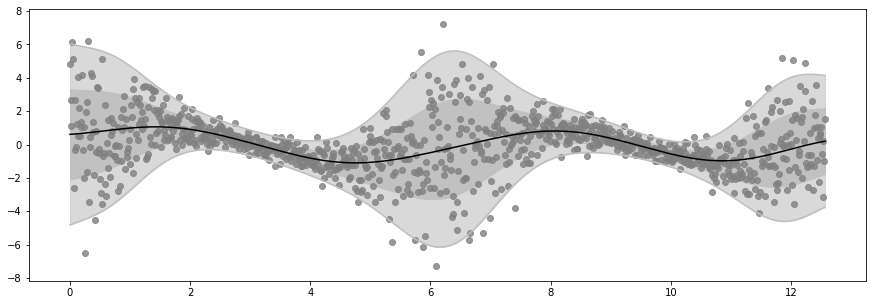

In [14]:
plt.figure(figsize=(15, 5))
for k in (1,2):
    x = X.squeeze()
    lb = (Ymean - k*Ystd).squeeze()
    ub = (Ymean + k*Ystd).squeeze()
    plt.fill_between(x, lb, ub, color='silver', alpha=1 - .05*k**3)
plt.plot(x, lb, color='silver')
plt.plot(x, ub, color='silver')
plt.plot(X, Ymean, color='black')
plt.scatter(X, Y, color='gray', alpha=.8)